# Classifying Handwritten Digits with Neural Networks

In [25]:
!wget https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv -O /tmp/mnist_train_small.csv

--2018-03-30 17:58:25--  https://storage.googleapis.com/mledu-datasets/mnist_train_small.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.11.176, 2607:f8b0:4007:804::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.11.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36523880 (35M) [application/octet-stream]
Saving to: ‘/tmp/mnist_train_small.csv’

/tmp/mnist_train_sm 100%[===================>]  34.83M  32.7MB/s    in 1.1s    

2018-03-30 17:58:26 (32.7 MB/s) - ‘/tmp/mnist_train_small.csv’ saved [36523880/36523880]



In [26]:
from jupyterthemes import jtplot
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

jtplot.style()
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

mnist_dataframe = pd.read_csv(
    io.open("/tmp/mnist_train_small.csv", "r"),
    sep=",",
    header=None)

mnist_dataframe = mnist_dataframe.head(10000)

mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
5767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7501,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4956,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4180,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
mnist_dataframe.loc[:, 1:]

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
5767,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
def parse_labels_and_features(dataset):
    """
    Extracts labels and features.
    
    Also scales the features
    Args:
        dataset: 'DataFrame' containing label on first column, followed by monochrome pixes values
                    on remaining
    Returns:
        A 'tuple' (labels,features):
            labels: 'Series'
            features: 'DataFrame'
    """
    labels = dataset[0]
    
    features = dataset.loc[:,1:784]
    features = features / 255
    return labels, features

In [29]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
training_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.8,0.2,1.0,0.2,0.0,0.0,0.0,0.0


In [30]:
validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
validation_examples.describe()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


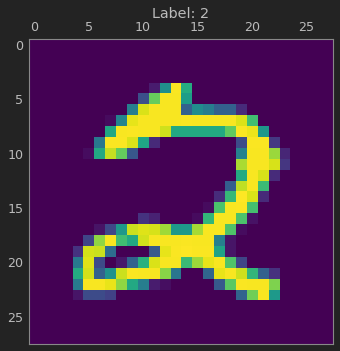

In [31]:
# show random example and label
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28,28))
ax.set_title("Label: %i" % training_targets.loc[rand_example])
ax.grid(False)

## Task 1: Build a Linear Model for MNIST

In [33]:
def construct_feature_columns():
    """
    Construct TensorFlow feature columns
    
    Returns:
        Set of feature columns
    """
    # magic number '784' comes from number of pixels in each img
    return set([tf.feature_column.numeric_column('pixels', shape=784)])

In [45]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
    """
    Custom input_fn for sending MNIST to estimator for training
    
    Args:
        features: The training features
        labels: The training labels
        batch_size: Batch size to use during training
        num_epochs: Number of pass throughs of the data set
        shuffle: True or False, whether to shuffle the data
    Returns:
        A function returning batches of training features and labels during training
    """
    def _input_fn(num_epochs=None, shuffle=True):
        # Input pipelines are reset with each call to .train().  To ensure model
        # gets a good sampling of data, even when number of steps is small, we
        # shuffle all the data before creating the Dataset object
        idx = np.random.permutation(features.index)
        raw_features = {"pixels":features.reindex(idx)}
        raw_targets = np.array(labels[idx])
        
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size).repeat(num_epochs)
        
        if shuffle:
            ds = ds.shuffle(10000)
            
        # return next batch of data
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    
    return _input_fn

In [46]:
def create_predict_fn(features, labels, batch_size):
    """
    Custom input_fn for sending mnist data to estimator for predictions
    
    Args:
        features: Features to have predictions on
        labels: Labels of the prediction examples
    Returns:
        Function that returns features and labels for predictions
    """
    def _input_fn():
        raw_features = { "pixels": features.values}
        raw_targets = np.array(labels)
        
        ds = Dataset.from_tensor_slices((raw_features, raw_targets))
        ds = ds.batch(batch_size)
        
        # return  next batch
        feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
        return feature_batch, label_batch
    
    return _input_fn

In [51]:
def train_linear_classification_model(
    learning_rate,
    batch_size,
    steps,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """
    Trains a linear classification model for the MNIST digits dataset.

    In addition to training, this function also prints training progress information,
    a plot of the training and validation loss over time, and a confusion
    matrix.

    Args:
        learning_rate: An `int`, the learning rate to use.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        training_examples: A `DataFrame` containing the training features.
        training_targets: A `DataFrame` containing the training labels.
        validation_examples: A `DataFrame` containing the validation features.
        validation_targets: A `DataFrame` containing the validation labels.

    Returns:
        The trained `LinearClassifier` object.
    """
    periods = 10
    steps_per_period = steps / periods
    
    training_input_fn = create_training_input_fn(training_examples, training_targets
                                                 , batch_size)
    predict_training_input_fn = create_predict_fn(training_examples, training_targets
                                                 , batch_size)
    predict_validation_input_fn = create_predict_fn(validation_examples, validation_targets
                                                   , batch_size)
    
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.LinearClassifier(
        feature_columns = construct_feature_columns(), 
        n_classes=10,
        optimizer=my_optimizer,
        config=tf.estimator.RunConfig(keep_checkpoint_max=1))
    
    print("Training model...")
    print("LogLoss error (validation)")
    training_errors = []
    validation_errors = []
    for period in range(0, periods):
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 10)
        
        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 10)
        
        # compute loss
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished")
    
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
    
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
    
    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)
    
    # output graph of loss metrics over periods
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()
    
    # output confusion matrix
    cm = metrics.confusion_matrix(final_predictions, validation_targets)
    cm_normalized = cm.astype("float32") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion Matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
    return classifier

Training model...
LogLoss error (validation)
  period 00 : 18.18
  period 01 : 11.80
  period 02 : 9.06
  period 03 : 6.84
  period 04 : 8.10
  period 05 : 6.99
  period 06 : 7.57
  period 07 : 6.16
  period 08 : 5.77
  period 09 : 6.59
Model training finished
Final accuracy (on validation data): 0.81


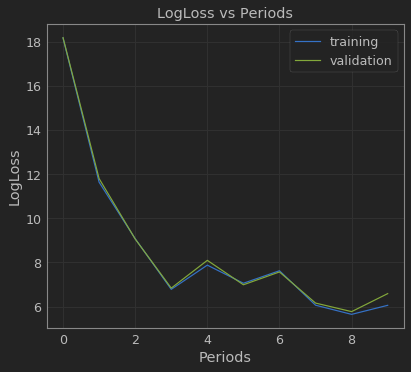

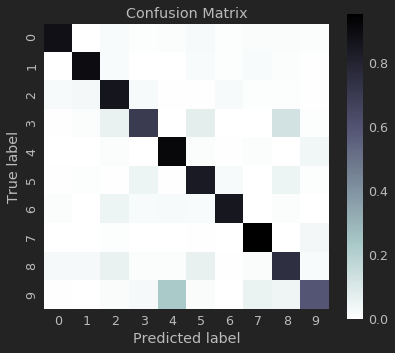

In [52]:
classifier = train_linear_classification_model(
    learning_rate=0.02,
    batch_size=10,
    steps=100, 
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [ ]:
classifier = train_linear_classification_model(
    learning_rate=0.05,
    batch_size=50,
    steps=500, 
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
LogLoss error (validation)
  period 00 : 4.84
  period 01 : 4.27
  period 02 : 3.70
  period 03 : 3.65
  period 04 : 3.61
  period 05 : 3.25
  period 06 : 3.30
  period 07 : 3.25
  period 08 : 3.16
